
<img alt='UCL' src="images/ucl_logo.png" align='center'>




[<img src="images/noun_post_2109127.svg" width="50" align='right'>](051_Model_Fitting.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](043_Weighted_interpolation.ipynb)



# 050 Models


## Introduction

In this session, we will consider the idea of a model in (Environmental) Science and discuss some examples. The material in this section brings together a lot of the techniques we have dealt with in previous sessions, so you should make sure you are up to speed with concepts like array processing, graph plotting and writing Python functions and scripts before attempting this.

You will need to understand the material in this section to be able to complete the second half of the submitted coursework.

## Prerequisites

You will need a good understanding of previous topics involving [`np/mgrid`](031_Numpy.ipynb#np.linspace,-np.arange,-np.mgrid) and [`np.newaxis`](032_More_numpy.ipynb#Reconciling-arrays:-np.newaxis). You should by know be familiar with other more basic material. 


## Models 

We can think of a model as a 'process' box encapsulating our understanding, or a proposal for our understanding, of some process. Two examples we will cover later are:

* a descriptive model of vegetation phenology
* a model of snow-melt

Such models make an *output prediction* will be some variable, or set of variables. For our two example models, these will be:

* LAI as a function of time
* river flow resulting from snow-melt

The **outputs** depend on the mechanics of our model and:

* some set of **driving data** (in our two models this will be simply time, and time and temperature, respectively) 
* some model parameters

The model parameters control the operation of the model. These could be related to the type of vegetation for a phenology model, or terms such as the thickness of snowpack in the case of a snow-melt model. Most often, the parameters will describe *states* and *rates*, for example, the current amount of water in a snowpack (state) or the rate at which water is released from the snowpack into runoff (rate).

![model](images/parameters1.png)

We will generally have access to the driving data for our model, and we will have some set of measurements that correspond to the output, but we may not know the values of the parameters to use.

![model](images/parameters2.png)

How can we use this to provide an estimate of the model parameters? We could make some educated guesses, based on previous experience with the model in different situations ('expert opinion'), and we might also be able to provide reasonable bounds for the parameters, again either based on previous experience with the model or sometimes simply from physical limits (e.g. some parameters cannot be negative). 

What we really want is a more objective way of estimating the parameters. This involves parameter optimisation, which is a whole field of science. We cannot cover that in this course, but we can introduce some of the main ideas to use in our codes.

Before moving on to more 'realistic' models, let's build a simple example model `model` we can learn from. 

This has two parameters `p[0]` and `p[0]` and a driver that represents time:

In [1]:
# simple model 
def model(driver,param):
    '''2-parameter quadratic model with noise'''
    return param[0] + param[1] * driver * driver

We will generate a dataset `measure` at time samples `tmdriver` to represent our measurements, We generate them with the model with a set of parameters and some additive noise. We will also generate a set of weights for the observations, which we will use to indicate their reliability:

In [2]:
import numpy as np

# time driver every 4 days for measurement
tmdriver = np.arange(0,365,4,dtype=np.int)
# generate a pseudo-measurement
p0 = np.array([0.4,0.0002])
measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
# just make up some weights for this exercise
measure_weight = (2 + np.random.random(tmdriver.shape))/4
# convert to std for plotting as previously
std = 1./np.sqrt(measure_weight) * 1.96

Now we forget that we know the parameters, make a guess that they are `[0.3,0.0001]`, and use the model to make a prediction `output`. Note that `output` exists every day, whereas the measurements are only every 4 days.

measurements: tmdriver shape (92,)
model output: tdriver shape  (365,)


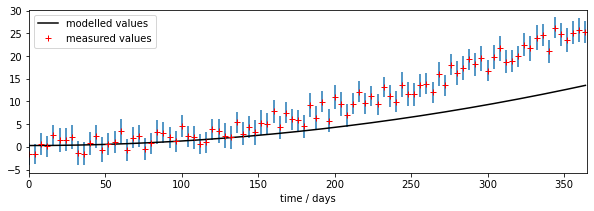

In [3]:
import matplotlib.pyplot as plt

# time driver every day
tdriver = np.arange(0,365,1,dtype=np.int)
# guess parameters
p = np.array([0.3,0.0001])
output  = model(tdriver,p)


# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tdriver,output,'k',label='modelled values')
axs.errorbar(tmdriver,measure,yerr=std,ls='none')
axs.plot(tmdriver,measure,'r+',label='measured values')
# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: tmdriver shape {tmdriver.shape}')
print(f'model output: tdriver shape  {tdriver.shape}')

We can see right away that there is a mis-match between the model outputs and the measurements.

### discrepancy and optimisation

We have a set of *observations* that correspond to the model outputs at some time samples. 

A simple operation we can do is to compare these then. We might suppose that a set of parameters that provides a lower discrepancy between observations and modelled values (we will often call this error) is *objectively better* than one with a poorer match. In that sense, what we would need to do would be to search for a set of parameters that which has the minimum error. Our search for parameters will be guided by any bounds we set. Then all we need to do is write some computer code that considers different values of the parameters and reports on the best (the optimal) match.


![model](images/parameters3.png)

That is a reasonable approach, and one we will take in these notes. We should be aware that when we do Science however, we need to take into account uncertainty, and also that there might be other constraints we want to put on the problem.

Uncertainty manifests itself at all stages of modelling and optimisation: the model itself will be uncertain, because of its nature as an abstraction of some process; the drivers will often be uncertain in their ability to the conditions at the actual place and time we are doing the modelling; and the measurements will be uncertain. We have treated uncertainty in other sections of these notes by applying a weight to observations, and we can take the same approach here. When we calculate error, for instance as the root mean square error between model predictions (output) and measurement, we can weight this to give a weighted error.

Before we can calculate the (weighted) error, we need to treat the outputs so that they match the time samples of the measurements. We can either match the observations to the measurements, or the measurements to the observations. The best approach with depend on circumstances, but it is often easiest to match the measurements to the observations:

In [4]:
# tmdriver time locations for measurements
# tdriver time locations for model outputs

# reconcile the model outputs 
# and measurements into same shape
# find the indices of the measurements
location_array = np.zeros_like(measure,dtype=np.int)
# populate location_array with indices of where measurement is
for i,t in enumerate(tmdriver):
    location = np.where(tdriver == t)
    if len(location[0]):
        location_array[i] = location[0][0]

In [5]:
# now mapping output to sample_output is easy
sample_output = output[location_array]

In [6]:
# now we can calculate the weighted discrepency 
error = (sample_output - measure)*measure_weight
error2 = error**2
rmse = np.sqrt(np.mean(error2))
print(f'RMSE: {rmse} for parameters {p}')

RMSE: 3.8529648592701515 for parameters [3.e-01 1.e-04]


measurements: measure shape (92,)
model output: output shape  (365,)
sample_output shape          (92,)


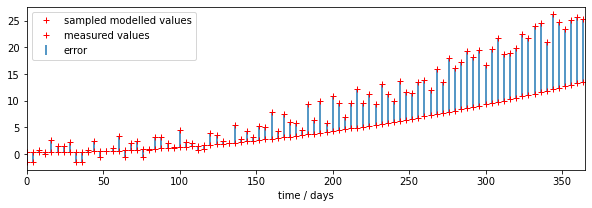

In [7]:
# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tmdriver,sample_output,'r+',label='sampled modelled values')
axs.plot(tmdriver,measure,'r+',label='measured values')
# plot the discrepencies in orange
axs.errorbar(tmdriver,measure,\
             yerr=[measure-measure,sample_output-measure],ls='none',\
             label='error')

# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: measure shape {measure.shape}')
print(f'model output: output shape  {output.shape}')
print(f'sample_output shape          {sample_output.shape}')

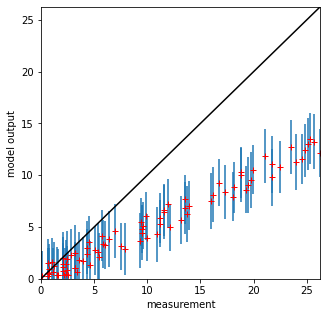

In [8]:
# scatter plot
fig, axs = plt.subplots(1,1,figsize=(5,5))
# max value over all
maxvalue = np.array([measure,sample_output]).max()
axs.set_xlim(0,maxvalue)
axs.set_ylim(0,maxvalue)

axs.plot(measure,sample_output,'r+')
axs.errorbar(measure,sample_output,yerr=std,ls='none')

axs.set_ylabel(f'model output')
axs.set_xlabel(f'measurement')
# 1:1 line
axs.plot([0,maxvalue],[0,maxvalue],'k')

### Varying the parameters

We have seen how, once we have aligned the model outputs and observations, we can calculate a weighted measure if error, RMSE here. So, so some given set of measurements, a model, and a set of model parameters, we can calculate the error:

![model](images/parameters4.png)

Re-generate the set of measurements:

In [9]:
import numpy as np

# simple model 
def model(driver,param):
    '''2-parameter quadratic model with noise'''
    return param[0] + param[1] * driver * driver

# time driver every 4 days for measurement
tmdriver = np.arange(0,365,4,dtype=np.int)
# generate a pseudo-measurement
p0 = np.array([0.4,0.0002])
# np.random.random(tmdriver.shape)-0.5 -> zero mean noise
measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
# just make up some weights for this exercise
measure_weight = (2 + np.random.random(tmdriver.shape))/4
# convert to std for plotting as previously
std = 1./np.sqrt(measure_weight) * 1.96

Recap on the core components so far, but setting the parameters to `numpy` arrays:

In [10]:

p0,p1 = np.array([0.1]),np.array([0.2])
tdriver = np.arange(0,365,1,dtype=np.int)
output  = model(tdriver,[p0,p1])


print(f'p0 shape:    {p0.shape}')
print(f'p1 shape:    {p1.shape}')
print(f'tdriver shape: {tdriver.shape}')
print(f'output shape:  {output.shape}')

p0 shape:    (1,)
p1 shape:    (1,)
tdriver shape: (365,)
output shape:  (365,)


We will now build a Look-up table (LUT) in parameter space to examine how the RMSE varies as we vary the model parameters.

Recall the material we covered in [032_More_numpy](032_More_numpy.ipynb#Reconciling-arrays:-np.newaxis). If we want to use a 2-D grid of shape `(Nxp,Nyp)` for `p0` and `p1`, we will have to make the driver shape `(1,1,365)` and the parameter shapes `(Nxp,Nyp,1)`:

In [11]:
# Use mgrid as previously to define a 2D grid of parameters
p0min,p0max,p0step = 0.0,10.0,1
p1min,p1max,p1step = 0.0,0.001,0.0001
p0,p1 = np.mgrid[p0min:p0max+p0step:p0step,\
                 p1min:p1max+p1step:p1step]

p0_ext      = p0[:,:,np.newaxis]
p1_ext      = p1[:,:,np.newaxis]
tdriver_ext = tdriver[np.newaxis,np.newaxis,:]

print(f'p0_ext shape:      {p0_ext.shape}')
print(f'p1_ext shape:      {p1_ext.shape}')
print(f'tdriver_ext shape: {tdriver_ext.shape}')

# we can now call the model with extended arrays
output  = model(tdriver_ext,[p0_ext,p1_ext])
print(f'output shape:      {output.shape}')

p0_ext shape:      (11, 11, 1)
p1_ext shape:      (11, 11, 1)
tdriver_ext shape: (1, 1, 365)
output shape:      (11, 11, 365)


To make a comparison with a measurement array, we have to first select time periods in `output` corresponding to the measurements. We have done this above, creating a mask `location_array` of the same dimensions as the measurements:

In [12]:
# get measurement mask
location_array = np.zeros_like(measure,dtype=np.int)
# populate location_array with indices of where measurement is
for i,t in enumerate(tmdriver):
    location = np.where(tdriver == t)
    if len(location[0]):
        location_array[i] = location[0][0]
        
print(f'location_array shape: {location_array.shape}')
print(f'measure shape:        {measure.shape}')
print(f'measure_weight shape: {measure_weight.shape}')

location_array shape: (92,)
measure shape:        (92,)
measure_weight shape: (92,)


Next, select the outputs (along axis 2) from the modelling that correspond to the measurements:

In [13]:
# now mapping output to sample_output is easy
sample_output = output[:,:,location_array]
print(f'output shape:        {output.shape}')
print(f'sample_output shape: {sample_output.shape}')

output shape:        (11, 11, 365)
sample_output shape: (11, 11, 92)


We need to be able to compare `sample_output` with `measure` and `measure_weight`, so lets do that to align with the parameter grid:

In [14]:
measure_ext        = measure[np.newaxis,np.newaxis,:]
measure_weight_ext = measure_weight[np.newaxis,np.newaxis,:]

print(f'measure_shape_ext:        {measure_ext.shape}')
print(f'measure_weight_ext shape: {measure_weight_ext.shape}')

measure_shape_ext:        (1, 1, 92)
measure_weight_ext shape: (1, 1, 92)


We can now perform element-wise operations involving `measure_ext`, `measure_weight_ext` and `sample_output`:

In [15]:
error_ext = (sample_output - measure_ext)*measure_weight_ext
error_ext = error_ext**2
print(f'error_ext shape: {error_ext.shape}')

error_ext shape: (11, 11, 92)


We now want the square root of the mean of this squared error term `error_ext` over time samples (axis 2):

rmse shape (11, 11)
-> rmse
[[ 7.72599055  3.97570464  0.95479577  3.87390666  7.62186203 11.40914191
  15.20639233 19.00763863 22.81088326 26.61526957 30.42036922]
 [ 7.26203053  3.52734766  1.06648288  4.33851359  8.09309118 11.88123141
  15.67862573 19.47986294 23.28306092 27.08739378 30.89244224]
 [ 6.82500472  3.14254356  1.46989147  4.84104245  8.58492361 12.36754805
  16.16173526 19.96089273 23.76263665 27.56589692 31.37012202]
 [ 6.42041555  2.84717809  1.99529962  5.37085918  9.09401706 12.86647871
  16.65477447 20.45010663 24.24917154 28.05045257 31.85315633]
 [ 6.05476892  2.67108789  2.56891118  5.92064262  9.61763087 13.37661199
  17.15688734 20.94693124 24.74225503 28.54075244 32.34130525]
 [ 5.73551758  2.63826505  3.16462213  6.48531681 10.15351887 13.89671424
  17.66730026 21.45083775 25.24150337 29.03650555 32.83434067]
 [ 5.47078986  2.75383711  3.77197643  7.06131034 10.69983699 14.42570725
  18.18531435 21.96133867 25.74655793 29.53743733 33.33204574]
 [ 5.26881066

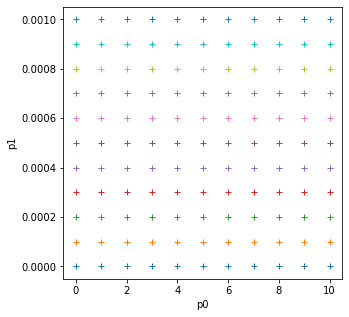

In [16]:
rmse = np.sqrt(np.mean(error_ext,axis=2))
print(f'rmse shape {rmse.shape}')
print(f'-> rmse\n{rmse}')
min_rmse = rmse.min()
print(f'min rmse\n{min_rmse}')

# use np.where to find the minimum
ix,iy= np.where(rmse == min_rmse)
print(ix,iy)

fig, axs = plt.subplots(1,1,figsize=(5,5))
axs.plot(p0,p1,'+')
axs.set_xlabel('p0')
axs.set_ylabel('p1')

print('2d parameter grid')

### Find the optimal parameters

Finally, to get the optimal model parameters, we need to identify the index of the minimum RMSE. This is potentially a multi-dimensional grid, so to find the index of the minimum, we first flatten the RMSE and parameter grids:

In [17]:
_rmse = rmse.flatten()
_p0 = p0.flatten()
_p1 = p1.flatten()
print(f'flattening changes the shape from {rmse.shape} to {_rmse.shape}')

flattening changes the shape from (11, 11) to (121,)


An equivalent operation is to `reshape` the array from `(Nx,Ny)` to `(Nx * Ny)`. Whilst we can do this multiplication explicitly, it is convenient to introduce `np.prod` which calculates the product of the elements in the array (in a similar fashion to the way `np.sum` calculates the sum). We can use:

    np.prod(rmse.shape)
    
to give the flattened dimension, and we use `np.reshape` to do the reshaping:

In [18]:
_rmse = rmse.reshape(np.prod(rmse.shape))
_p0 = p0.reshape(np.prod(p0.shape))
_p1 = p1.reshape(np.prod(p1.shape))
print(f'flattening this way changes the shape from {rmse.shape} to {_rmse.shape}')

flattening this way changes the shape from (11, 11) to (121,)


The index in the flattened array of the minimum value is found with `np.argmin`:

In [19]:
imin = np.argmin(_rmse)
print(f'index: {imin}: {_p0[imin]},{_p1[imin]}')

index: 2: 0.0,0.0002


To convert the index back to the unflattened array, we can use:

In [20]:
# generate indices
ixi,iyi = np.indices(p0.shape)
# flatten
_ix = ixi.reshape(np.prod(ixi.shape))
_iy = iyi.reshape(np.prod(iyi.shape))

ix,iy = _ix[imin],_iy[imin]
print(f'2-D index is {ix},{iy}')

2-D index is 0,2


Of the 11 x 11  combinations of parameters we examined, the parameters `[0.0,0.0002]` provide the best fit to the data. We had generated the 'measurements' with:

    p0 = np.array([0.4,0.0002])

We can find it useful to visualise the RMSE 'error surface' and then plot the measurements and forward model:

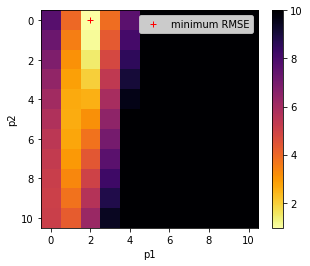

In [21]:
import matplotlib.pyplot as plt
# Plot the RMSE values returned from this as an image

# plot it
fig, axs = plt.subplots(1,1,figsize=(5,4))
im = axs.imshow(rmse,interpolation="nearest",\
                vmax=10,cmap=plt.cm.inferno_r)
fig.colorbar(im, ax=axs)
axs.set_xlabel('p1')
axs.set_ylabel('p2')
plt.plot([iy],[ix],'r+',label="minimum RMSE")
axs.legend(loc='best')

[0.     0.0002]
measurements: tmdriver shape (92,)
model output: tdriver shape  (365,)


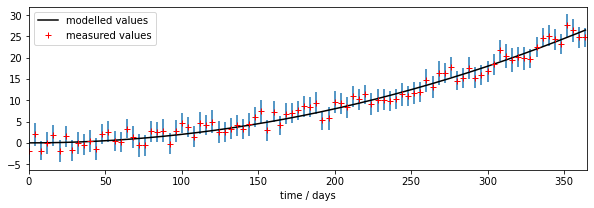

In [22]:
import matplotlib.pyplot as plt

# time driver every day
tdriver = np.arange(0,365,1,dtype=np.int)
# get the parameters we siolved for
p = np.array([_p0[imin],_p1[imin]])
print(p)
output  = model(tdriver,p)

# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tdriver,output,'k',label='modelled values')
axs.errorbar(tmdriver,measure,yerr=std,ls='none')
axs.plot(tmdriver,measure,'r+',label='measured values')
# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: tmdriver shape {tmdriver.shape}')
print(f'model output: tdriver shape  {tdriver.shape}')

The parameter estimation code is effective and quite fast in this case. 
We are using quite a sparse LUT (121 points) in 2-D, but the model is able to mimic the (pseudo) observations very well, even with rather a quantised LUT. 

When we plot the RMSE as a function of the model parameters, we confirm 
the solution found by searching the LUT for the minimum. We notice however that
the second of the model parameters can depart considerably from that used originally
to generate the pseudo observation. The reason for this is apparent in the RMSE plots:
the 'error surface' has a long-narrow valley in this dimension, indicating a high
parameter uncertainty.

When we forward model using the parameters we solved for, we see that the solution 
found gives a good fit to the observations, within their error bars. This further informs us
that the sensitivity to the second model parameter is quite low. 

### LUT inversion

This approach is called a Look-up table (LUT) inversion. It has the advantage of being quite fast if the total number of samples in the LUT can be kept down in number. This means that the limits to the problem need to be carefully considered: if your LUT inversion produces a supposed optimum parameter value that is on the bounds of the parameter space, then this can often be quite suspect: it may be that you just haven't sampled over a large-enough parameter space. The result is quantised to the LUT spacing if you use the simple approach here, but that will be fine for many applications. This is really only an appropriate method if you have a small number of parameters that you are solving for: i.e. a 1-, 2- or perhaps 3-Dimensional problem. If your model has more parameters, you may have to adopt a multi-pass strategy for parameter searching, or use a method other than LUT inversion.

#### Exercise 1

In a file `lut_RMSE.py` do the following:

        import numpy as np
        # define the min and max and step for the grid we want
        p0min,p0max,p0step = 0.0,10.0,0.05
        p1min,p1max,p1step = 0.0,0.001,0.000005

        gridp0,gridp1 = np.mgrid[p0min:p0max+p0step:p0step,\
                                 p1min:p1max+p1step:p1step]


* Write a function `gen_lut` to return a 2D parameter (Look up table -- LUT) grid using `np.mgrid` as above as `param = [gridp0,gridp1]`

        # simple model 
        def model(driver,param):
            '''2-parameter quadratic model with noise'''
            return param[0] + param[1] * driver * driver
          
* Write a function `model` to describe the model we will be using from the code above
 
        location_array = np.zeros_like(measure,dtype=np.int)
        # populate location_array with indices of where measurement is
        for i,t in enumerate(tmdriver):
            location = np.where(tdriver == t)
            if len(location[0]):
                location_array[i] = location[0][0]

 * A function `get_location_array` that takes as input:
 
        * tdriver:        array of (Nt,) floats of the day of year on which to do modelling
        * measure:        array of (Nm,) floats of measurements over sampled days of the year     
        * tmdriver:       array of (Nm,) integers: the days on which the measurements occur 
         
   and returns `location_array` array (Nm,) integers of the days of the measurements
            
        # code to use
        # time driver every 4 days for measurement    
        tmdriver = np.arange(0,365,4,dtype=np.int)
        # generate a pseudo-measurement
        p0 = np.array([0.4,0.0002])
        measure = model(tmdriver,p0) + 5*(np.random.random(tmdriver.shape)-0.5)
        # just make up some weights for this exercise
        measure_weight = (2 + np.random.random(tmdriver.shape))/4
        
        
* Write a function `gen_meas` to generate a pseudo-measurement based on the model and some noise. It should print the value of the parameters used in the model, and return `tmdriver, measure, measure_weight` corresponding to:

        * tdriver:        array of (Nt,) floats of the day of year on which to do modelling
        * measure:        array of (Nm,) floats of measurements over sampled days of the year
        * measure_weight: array of (Nm,) floats of the weights associated with the measurements

* Write a function `lut_RMSE` that takes as inputs:

        * `param`:          list of `[p0,p1]` with `p0` and `p1` being arrays of shape `(Np0,Np1)` representing a the LUT grid over parameter space
        * `tdriver`:         array of (Nt,) floats of the day of year on which to do modelling
        * `measure:`        array of (Nm,) floats of measurements over sampled days of the year
        * `measure_weight`: array of (Nm,) floats of the weights associated with the measurements
        * `tmdriver`:       array of (Nm,) integers: the days on which the measurements occur 
    
 That runs the model `model(tdriver,param)`, uses `get_location_array` to sample the model outputs coirresponding to the measurements, and calculates the weighted RMSE between the measurements and the modelled values for each parameter pair, and returns a grid of shape `(Np0,Np1)` values of RMSE associated with each parameter pair.
 
 * Write a function `runner()` that 
    * generates tdriver, the array of (365,) floats of the day of year on which to do modelling
    * gets a LUT `param` from `gen_lut`
    * gets a pseudo-measurement from `gen_meas`
    * gets a 2-D array of RMSE corresponding to the parameter grid
    * calculated and prints the value of the parameters corresponding to the minimum RMSE,
    * returns the RMSE array, the LUT, and the measurements
 
* Run `runner()` in a notebook
* Plot the RMSE values returned from this as an image
* Verify that you have identified the minimum RMSE
* Set different parameters in `gen_meas` to generate a different pseudo-measurement and repeat the process.
* Comment on the results

In [23]:
# ANSWER
!geog0111/lut_RMSE.py

original parameters: [0.4, 0.0002]
min rmse
2.235991886229933
index: 1045: 0.25,0.0002
parameters: 0.25 0.0002


In [24]:
# ANSWER
import numpy as np
# Run runner() in a notebook
from geog0111.lut_RMSE import runner, model, gen_lut
RMSE,tdriver,(measure,measure_weight,tmdriver) = runner()
gridp0,gridp1 = gen_lut()

original parameters: [0.4, 0.0002]
min rmse
2.278485659275898
index: 1850: 0.45,0.00020500000000000002
parameters: 0.45 0.00020500000000000002


In [25]:
# confirm
# use argmin to find min, but need to flatten/reshape arrays first
_rmse = RMSE.reshape(np.prod(RMSE.shape))
_p0 = param[0].reshape(np.prod(param[0].shape))
_p1 = param[1].reshape(np.prod(param[1].shape))

imin = np.argmin(_rmse)

print(f'index: {imin}: {_p0[imin]},{_p1[imin]}')
ixi,iyi = np.indices(param[0].shape)
# flatten
_ix = ixi.reshape(np.prod(ixi.shape))
_iy = iyi.reshape(np.prod(iyi.shape))
ix,iy = _ix[imin],_iy[imin]
p = np.array([_p0[imin],_p1[imin]])
print(f'parameters: {p[0]} {p[1]}')

NameError: name 'param' is not defined

In [ ]:
import matplotlib.pyplot as plt
# Plot the RMSE values returned from this as an image

# plot it
fig, axs = plt.subplots(1,1,figsize=(10,8))
im = axs.imshow(RMSE,interpolation="nearest",\
                vmax=10,cmap=plt.cm.inferno_r)
fig.colorbar(im, ax=axs)
axs.set_xlabel('p1')
axs.set_ylabel('p2')
plt.plot([iy],[ix],'r+',label="minimum RMSE")
axs.legend(loc='best')

In [ ]:
import numpy as np
from geog0111.lut_RMSE import gen_meas,model,lut_RMSE

# change the original parameters 

tdriver = np.arange(0,365,1,dtype=np.int)
param = gen_lut()
tmdriver,measure,measure_weight = gen_meas(p0=[0.0,0.0005])
std = 1./np.sqrt(measure_weight) * 1.96
RMSE = lut_RMSE(param,tdriver,measure,measure_weight,tmdriver)
min_rmse = RMSE.min()
ix,iy = np.where(RMSE == min_rmse)
print(gridp0[ix,iy],gridp1[ix,iy],RMSE[ix,iy])
print(f'min rmse\n{min_rmse}')
fig, axs = plt.subplots(1,1,figsize=(10,8))
im = axs.imshow(RMSE,interpolation="nearest",\
                vmax=10,cmap=plt.cm.inferno_r)
fig.colorbar(im, ax=axs)
axs.set_xlabel('p1')
axs.set_ylabel('p2')
plt.plot([iy],[ix],'r+',label="minimum RMSE")
axs.legend(loc='best')

In [ ]:
import matplotlib.pyplot as plt

# time driver every day
tdriver = np.arange(0,365,1,dtype=np.int)
# get the parameters we siolved for
p = np.array([gridp0[ix,iy],gridp1[ix,iy]]).flatten()
print(p)
output  = model(tdriver,p)

# plot
fig, axs = plt.subplots(1,1,figsize=(10,3))
axs.set_xlim(0,365)
axs.plot(tdriver,output,'k',label='modelled values')
axs.errorbar(tmdriver,measure,yerr=std,ls='none')
axs.plot(tmdriver,measure,'r+',label='measured values')
# set legend now
axs.legend(loc='best')
axs.set_xlabel(f'time / days')

print(f'measurements: tmdriver shape {tmdriver.shape}')
print(f'model output: tdriver shape  {tdriver.shape}')

In [ ]:
# Comment on the results

msg = '''
We confirm the findings above, but are now able to see the form of the error surface in much greater detail. 
'''
print(msg)

## Summary

In this notebook, we have discussed some generic aspects of models. We note that they typically have some set of driving data (even if that is just time, as in the example here), and a set of parameters that control the model response. 

We have seen how we can apply the concepts we learned in the [`numpy`](032_More_numpy.ipynb#032-More-numpy) sessions to build a parameter LUT and rapidly calculate a goodness of fit measure between some set of observations and the model output. We have seen how to use this to provide an estimate of the model parameters. This is known as model calibration. 

Technically, we have seen how we need to reconcile the dimensions of the parameter LUT and the model outputs in `numpy` using `np.newaxis` so we can calculate the model outputs for all parameters in the LUT efficiently, all at once. We have seen that parameter estimation in this way can be effective, but may be limited to a relatively small-dimensional problem. If we have a larger number of parameters, we may need to devise other strategies for parameter estimation.


[<img src="images/noun_post_2109127.svg" width="50" align='right'>](051_Model_Fitting.ipynb)
[<img src="images/noun_pre_2109128.svg" width="50" align='right'>](043_Weighted_interpolation.ipynb)

